##### associated log files: logs, logs_dice
##### saved model: unet_supervised_kmeans_train.h5

In [1]:
import tensorflow as tf
# import tensorflow_addons as tfa

from tensorflow import keras
from tensorflow.keras import backend as K
import numpy as np
import skimage
from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.color import rgb2gray
from sklearn import cluster

import matplotlib as plt

import os

%load_ext tensorboard
os.environ['TENSORBOARD_BINARY'] = '/Users/preetam/opt/anaconda3/envs/ml/bin/tensorboard'

In [2]:
train_set_images = './pipeline_outputs/data/train/'
train_set_kmeans = './kmeans_segm/data/train/'

In [3]:
img_file_paths = [f for f in os.listdir(train_set_images) if os.path.isfile(os.path.join(train_set_images, f))]
img_file_paths = [train_set_images + f for f in img_file_paths]
img_file_paths.sort()

# img_file_paths

In [4]:
kmeans_file_paths = [f for f in os.listdir(train_set_kmeans) if os.path.isfile(os.path.join(train_set_kmeans, f))]
kmeans_file_paths = [train_set_kmeans + f for f in kmeans_file_paths]
kmeans_file_paths.sort()

# kmeans_file_paths

In [5]:
NUM_IMAGES = len(img_file_paths)
IMG_WIDTH = 256
IMG_HEIGHT = 256

X_train = np.zeros( (NUM_IMAGES, IMG_WIDTH, IMG_HEIGHT, 1), dtype=np.float32 )
y_train = np.zeros( (NUM_IMAGES, IMG_WIDTH, IMG_HEIGHT, 1), dtype=np.uint8 )

for img, mask, i in zip(img_file_paths, kmeans_file_paths, range(NUM_IMAGES)):
    img_curr = imread(img)
    img_curr = resize(img_curr, (IMG_WIDTH, IMG_HEIGHT, 1), mode="constant", preserve_range=True)
    X_train[i] = img_curr
    
    
    
    
    img_curr = (np.int64(imread(img))).reshape((-1,1))
    k_m = cluster.KMeans(n_clusters=5, n_init=4)
    k_m.fit(img_curr)
    
    values, labels = np.int64(k_m.cluster_centers_.squeeze()), np.int64(k_m.labels_)
    img_segm = np.choose(labels, values)
    img_segm.shape = (256, 256, 1)
    
    pix_val = 0.0
    for value in (np.unique(img_segm)):
        img_segm = np.where(img_segm == value, pix_val, img_segm)
        pix_val += 0.25
        
    img_segm = np.where(img_segm > 0.5, 1, img_segm)
    img_segm = np.where(img_segm <= 0.5, 0, img_segm)
    img_segm = np.uint8(img_segm)
    y_train[i] = img_segm

#     mask_curr = imread(mask)
#     mask_curr = resize(mask_curr, (IMG_WIDTH, IMG_HEIGHT, 1), mode="constant", preserve_range=True)
#     y_train[i] = mask_curr
    
#     if i == 10:
#         print(np.unique(img_segm))
#         print(img_segm.shape)
#         imshow(img_segm)

/Users/preetam/opt/anaconda3/envs/ml/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


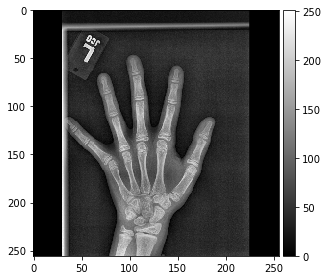

In [6]:
imshow(X_train[10], cmap=plt.cm.gray)

/Users/preetam/opt/anaconda3/envs/ml/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


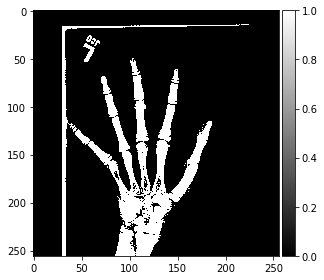

In [7]:
imshow(y_train[10], cmap=plt.cm.gray)

In [8]:
inputs = keras.layers.Input( (256, 256, 1) )
s = keras.layers.Lambda(lambda x: x / 255.)(inputs)

# contracting path
c1 = keras.layers.Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(s)
c1 = keras.layers.Dropout(0.1)(c1)
c1 = keras.layers.Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c1)
p1 = keras.layers.MaxPooling2D( (2,2) )(c1)

c2 = keras.layers.Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p1)
c2 = keras.layers.Dropout(0.1)(c2)
c2 = keras.layers.Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c2)
p2 = keras.layers.MaxPooling2D( (2,2) )(c2)

c3 = keras.layers.Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p2)
c3 = keras.layers.Dropout(0.2)(c3)
c3 = keras.layers.Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c3)
p3 = keras.layers.MaxPooling2D( (2,2) )(c3)

c4 = keras.layers.Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p3)
c4 = keras.layers.Dropout(0.2)(c4)
c4 = keras.layers.Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c4)
p4 = keras.layers.MaxPooling2D( (2,2) )(c4)

c5 = keras.layers.Conv2D(256, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p4)
c5 = keras.layers.Dropout(0.3)(c5)
c5 = keras.layers.Conv2D(256, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c5)

# expansive path
u6 = keras.layers.Conv2DTranspose(128, (2,2), strides=(2,2), padding="same")(c5)
u6 = keras.layers.concatenate([u6, c4])
c6 = keras.layers.Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u6)
c6 = keras.layers.Dropout(0.2)(c6)
c6 = keras.layers.Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c6)

u7 = keras.layers.Conv2DTranspose(64, (2,2), strides=(2,2), padding="same")(c6)
u7 = keras.layers.concatenate([u7, c3])
c7 = keras.layers.Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u7)
c7 = keras.layers.Dropout(0.2)(c7)
c7 = keras.layers.Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c7)

u8 = keras.layers.Conv2DTranspose(32, (2,2), strides=(2,2), padding="same")(c7)
u8 = keras.layers.concatenate([u8, c2])
c8 = keras.layers.Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u8)
c8 = keras.layers.Dropout(0.1)(c8)
c8 = keras.layers.Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c8)

u9 = keras.layers.Conv2DTranspose(16, (2,2), strides=(2,2), padding="same")(c8)
u9 = keras.layers.concatenate([u9, c1], axis=3)
c9 = keras.layers.Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u9)
c9 = keras.layers.Dropout(0.1)(c9)
c9 = keras.layers.Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c9)

outputs = keras.layers.Conv2D(1, (1,1), activation="sigmoid")(c9)

In [9]:
# def DiceLoss(y_true, y_pred):
#     smooth=1e-6
    
#     #flatten label and prediction tensors
#     inputs = tf.cast(y_pred, dtype=tf.float32)
#     targets = tf.cast(y_true, dtype=tf.float32)
    
#     intersection = K.sum(K.dot(targets, inputs))
#     dice = (2*intersection + smooth) / (K.sum(targets) + K.sum(inputs) + smooth)
#     return 1 - dice

def dice_loss(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    
    y_true_f = tf.cast(y_true_f, dtype=tf.float32)
    y_pred_f = tf.cast(y_pred_f, dtype=tf.float32)
    
    intersection = K.sum(y_true_f * y_pred_f)
    dice = (2. * intersection + 0.0001) / (K.sum(y_true_f) + K.sum(y_pred_f) + 0.0001)
    return (1 - dice)

In [10]:
model = keras.Model(inputs=[inputs], outputs=[outputs])
# model.compile(optimizer="adam", loss=dice_loss, metrics=[tf.keras.metrics.MeanIoU(num_classes=1)])
model.compile(optimizer="adam", loss=dice_loss, metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 256, 256, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 160         lambda[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 256, 256, 16) 0           conv2d[0][0]                     
______________________________________________________________________________________________

In [11]:
checkpointer = keras.callbacks.ModelCheckpoint('unet_supervised_kmeans_train.h5', verbose=1, save_best_only=True)

In [12]:
callbacks = [
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=3),
    keras.callbacks.TensorBoard(log_dir='logs_dice'),
    checkpointer
]

In [13]:
results = model.fit(X_train, y_train, validation_split=0.3, batch_size=16, epochs=25, callbacks=callbacks)

Train on 123 samples, validate on 54 samples
Epoch 1/25
112/123 [==========================>...] - ETA: 10s - loss: 0.5472 - accuracy: 0.3380
Epoch 00001: val_loss improved from inf to 0.50682, saving model to unet_supervised_kmeans_train.h5
123/123 [==============================] - 512s 4s/sample - loss: 0.5391 - accuracy: 0.3380 - val_loss: 0.5068 - val_accuracy: 0.2850
Epoch 2/25
112/123 [==========================>...] - ETA: 10s - loss: 0.4799 - accuracy: 0.3232
Epoch 00002: val_loss improved from 0.50682 to 0.48021, saving model to unet_supervised_kmeans_train.h5
123/123 [==============================] - 151s 1s/sample - loss: 0.4853 - accuracy: 0.3238 - val_loss: 0.4802 - val_accuracy: 0.4107
Epoch 3/25
112/123 [==========================>...] - ETA: 15s - loss: 0.4738 - accuracy: 0.4507
Epoch 00003: val_loss improved from 0.48021 to 0.47505, saving model to unet_supervised_kmeans_train.h5
123/123 [==============================] - 187s 2s/sample - loss: 0.4778 - accuracy: 0.4

In [14]:
results = model.predict(X_train, verbose=1)

177/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

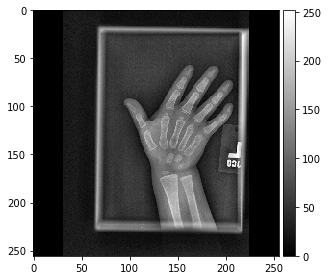

In [82]:
imshow(X_train[8], cmap=plt.cm.gray)

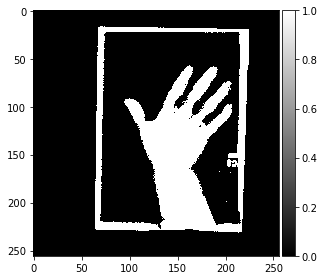

In [75]:
imshow(y_train[8], cmap=plt.cm.gray)

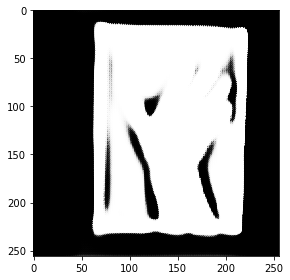

In [74]:
imshow(results[8], cmap=plt.cm.gray)

In [24]:
%tensorboard --logdir logs_dice

In [81]:
tensor = tf.constant([[0.0,1.7,2.2], [0.0, 0.71, 1.0]])
tensor = tf.cast( tf.cast(tensor + 0.5, tf.int32), tf.float32 )

tensor

<tf.Tensor: id=6321, shape=(2, 3), dtype=float32, numpy=
array([[0., 2., 2.],
       [0., 1., 1.]], dtype=float32)>